# Next Pitch Prediction using LSTMs

The first series of tests will be carried out using basic LSTMs. An LSTM is a type of recurrent neural network that is capable of learning long-term dependencies. This is particularly useful for time series data, such as the pitch sequences in this dataset.

## Data loading and sequencing

In [1]:
import os
import tensorflow as tf

os.chdir('..')
tf.keras.utils.set_random_seed(42)

In [2]:
from utils import preprocessing
from sklearn.model_selection import train_test_split

X, y_pitch, y_vertical, y_horizontal = preprocessing.get_sequences(os.path.join('data', 'raw', 'wade_miley_15-21.csv'))

# Split the data into training, validation, and testing sets
X_train, X_temp, y_pitch_train, y_pitch_temp, y_vertical_train, y_vertical_temp, y_horizontal_train, y_horizontal_temp = train_test_split(
    X, y_pitch, y_vertical, y_horizontal, test_size=0.4, random_state=42)

X_val, X_test, y_pitch_val, y_pitch_test, y_vertical_val, y_vertical_test, y_horizontal_val, y_horizontal_test = train_test_split(
    X_temp, y_pitch_temp, y_vertical_temp, y_horizontal_temp, test_size=0.5, random_state=42)

num_pitches = y_pitch.shape[1]
num_vertical_locs = y_vertical.shape[1]
num_horizontal_locs = y_horizontal.shape[1]

In [3]:
def build_network(input_layer, num_targets, name='', num_hidden_units=128, num_hidden_layers=1, activation='relu', reg=None, dropout=None):
    
    # Hidden layers
    x = input_layer
    for i in range(num_hidden_layers - 1):
        if reg:
            x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, return_sequences=True, kernel_regularizer=reg)(x)
        else:
            x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, return_sequences=True)(x)
        if dropout:
            x = tf.keras.layers.Dropout(dropout)(x)
    
    # Last hidden layer without return_sequences
    if reg:
        x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, return_sequences=False, kernel_regularizer=reg)(x)
    else:
        x = tf.keras.layers.LSTM(units=num_hidden_units, activation=activation, return_sequences=False)(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout)(x)

    # Output layer
    outputs = tf.keras.layers.Dense(units=num_targets, activation='softmax', name=name)(x)

    return outputs

In [4]:
def build_model(hp):
      # Define the input layer
      input_layer = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

      pitch_output = build_network(input_layer, num_targets=num_pitches, name='pitch_output',
                                   num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                   num_hidden_units=hp.Int('num_hidden_units', min_value=128, max_value=512, step=128),
                                   activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']))
      vertical_output = build_network(input_layer, num_targets=num_vertical_locs, name='vertical_output',
                                      num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                      num_hidden_units=hp.Int('num_hidden_units', min_value=128, max_value=512, step=128),
                                      activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']))
      horizontal_output = build_network(input_layer, num_targets=num_horizontal_locs, name='horizontal_output',
                                        num_hidden_layers=hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1),
                                        num_hidden_units=hp.Int('num_hidden_units', min_value=128, max_value=512, step=128),
                                        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid']))

      # Combine the models
      ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[pitch_output, vertical_output, horizontal_output])

      # Compile the model
      ensemble_model.compile(optimizer='adam',
                        loss={'pitch_output': 'categorical_crossentropy',
                              'vertical_output': 'categorical_crossentropy',
                              'horizontal_output': 'categorical_crossentropy'},
                        metrics=['accuracy', 'accuracy', 'accuracy'])
      return ensemble_model

In [16]:
vertical_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_vertical_output_accuracy',
    patience=20,
    restore_best_weights=True,
    mode='max'
)

horizontal_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_horizontal_output_accuracy',
    patience=20,
    restore_best_weights=True,
    mode='max'
)

pitch_early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_pitch_output_accuracy',
    patience=20,
    restore_best_weights=True,
    mode='max'
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_ensemble_model.keras',
    monitor='val_vertical_output_accuracy',
    save_best_only=True,
    mode='max'
)

In [10]:
import keras_tuner

tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=[keras_tuner.Objective('val_vertical_output_accuracy', direction='max'),
               keras_tuner.Objective('val_horizontal_output_accuracy', direction='max'),
               keras_tuner.Objective('val_pitch_output_accuracy', direction='max')],
    max_trials=5,
    project_name='self_learned_embeddings'
)

tuner.search(X_train, 
             {'pitch_output': y_pitch_train,
              'vertical_output': y_vertical_train,
              'horizontal_output': y_horizontal_train},
             epochs=200, batch_size=64, 
             validation_data=(X_val, 
                              {'pitch_output': y_pitch_val,
                               'vertical_output': y_vertical_val,
                               'horizontal_output': y_horizontal_val}),
             callbacks=[pitch_early_stopping_callback, vertical_early_stopping_callback, horizontal_early_stopping_callback],
            )

best_model = tuner.get_best_models()[0]

best_model.summary()

Trial 5 Complete [00h 03m 06s]
multi_objective: -1.5444882214069366

Best multi_objective So Far: -1.7615485787391663
Total elapsed time: 00h 23m 47s


c:\Users\SEBAS\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6, 36)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 6, 128)    │     84,480 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 6, 128)    │     84,480 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 6, 128)    │     84,480 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 128)       │    131,584 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 128)       │    131,584 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 128)       │    131,584 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch_output        │ (None, 8)         │      1,032 │ lstm_1[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vertical_output     │ (None, 3)         │        387 │ lstm_3[0][0]      │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ horizontal_output   │ (None, 3)         │        387 │ lstm_5[0][0]      │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 649,998 (2.48 MB)

 Trainable params: 649,998 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model = build_model(tuner.get_best_hyperparameters()[0])
# Train the model
history = model.fit(X_train, 
                             {'pitch_output': y_pitch_train,
                              'vertical_output': y_vertical_train,
                              'horizontal_output': y_horizontal_train},
                             epochs=200, batch_size=64, 
                             validation_data=(X_val, 
                                              {'pitch_output': y_pitch_val,
                                               'vertical_output': y_vertical_val,
                                               'horizontal_output': y_horizontal_val}),
                             callbacks=[pitch_early_stopping_callback, vertical_early_stopping_callback, horizontal_early_stopping_callback],
                             verbose=0
                            )

model = tf.keras.models.load_model('best_ensemble_model.keras')
test_loss, pitch_accuracy, vertical_accuracy, horizontal_accuracy = model.evaluate(X_test, 
                                                                            {'pitch_output': y_pitch_test,
                                                                             'vertical_output': y_vertical_test,
                                                                             'horizontal_output': y_horizontal_test})
print(f"Pitch Test Accuracy: {pitch_accuracy}")
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

KeyboardInterrupt: 

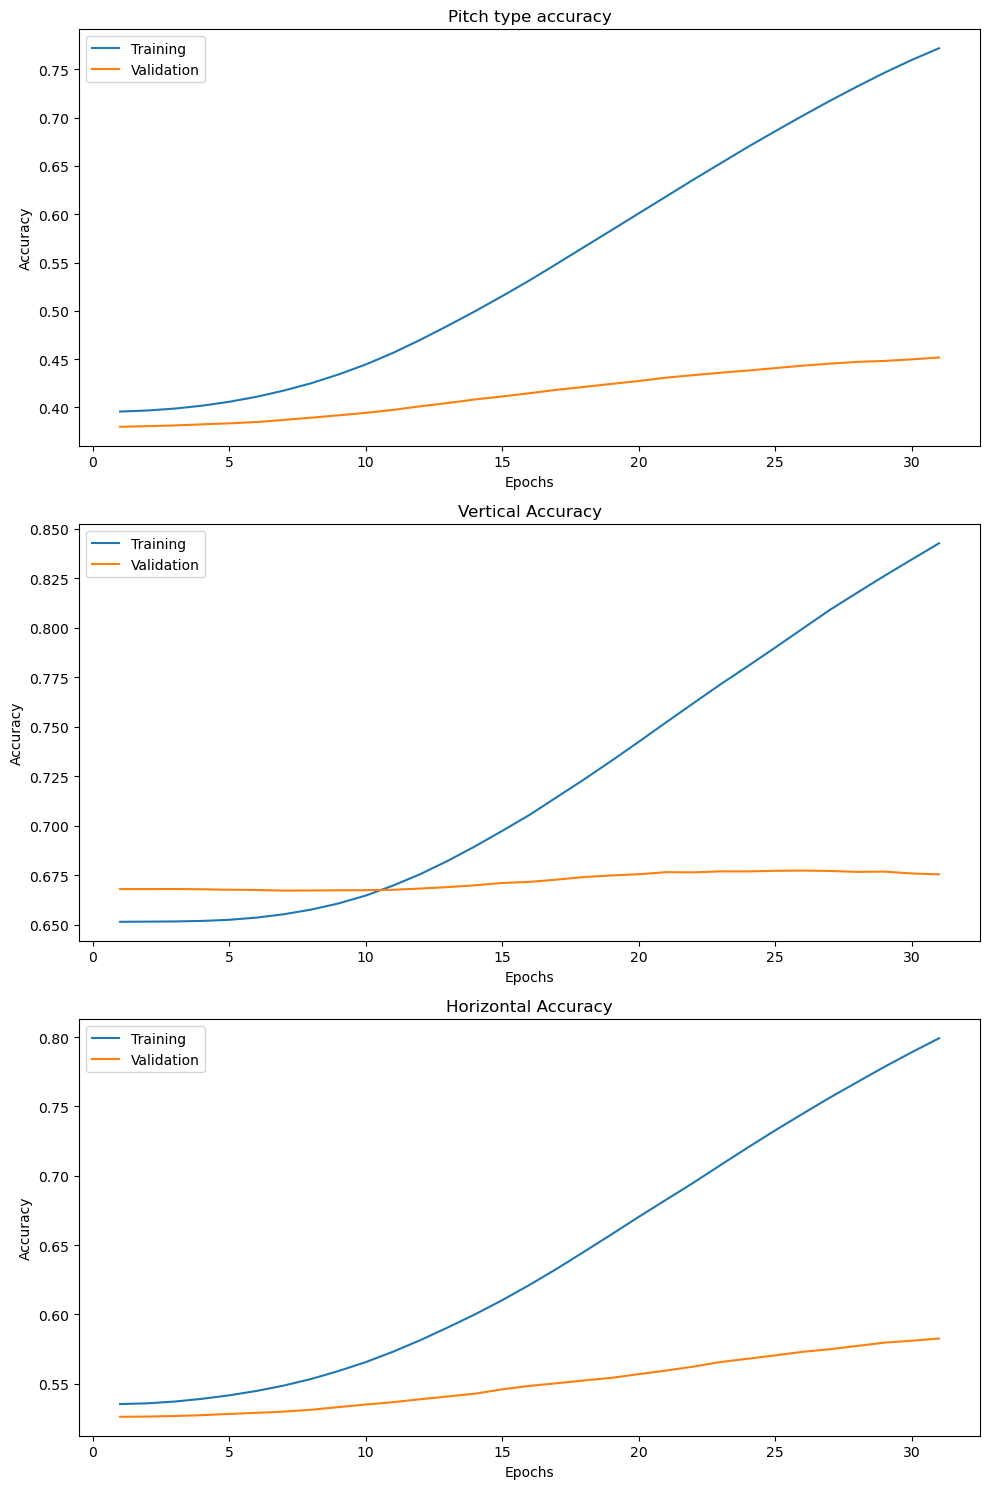

In [15]:
from utils.plot_utils import smooth_curve
import matplotlib.pyplot as plt

# Smooth the accuracy curves
smooth_pitch_accuracy = smooth_curve(history.history['pitch_output_accuracy'][5:])
smooth_val_pitch_accuracy = smooth_curve(history.history['val_pitch_output_accuracy'][5:])
smooth_vertical_accuracy = smooth_curve(history.history['vertical_output_accuracy'][5:])
smooth_val_vertical_accuracy = smooth_curve(history.history['val_vertical_output_accuracy'][5:])
smooth_horizontal_accuracy = smooth_curve(history.history['horizontal_output_accuracy'][5:])
smooth_val_horizontal_accuracy = smooth_curve(history.history['val_horizontal_output_accuracy'][5:])

# Create a grid of plots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot pitch accuracy
axs[0].plot(range(1, len(smooth_pitch_accuracy) + 1), smooth_pitch_accuracy, label='Training')
axs[0].plot(range(1, len(smooth_val_pitch_accuracy) + 1), smooth_val_pitch_accuracy, label='Validation')
axs[0].set_title('Pitch type accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot vertical accuracy
axs[1].plot(range(1, len(smooth_vertical_accuracy) + 1), smooth_vertical_accuracy, label='Training')
axs[1].plot(range(1, len(smooth_val_vertical_accuracy) + 1), smooth_val_vertical_accuracy, label='Validation')
axs[1].set_title('Vertical Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Plot horizontal accuracy
axs[2].plot(range(1, len(smooth_horizontal_accuracy) + 1), smooth_horizontal_accuracy, label='Training')
axs[2].plot(range(1, len(smooth_val_horizontal_accuracy) + 1), smooth_val_horizontal_accuracy, label='Validation')
axs[2].set_title('Horizontal Accuracy')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Accuracy')
axs[2].legend()

plt.tight_layout()
plt.show()